Compare several models on Imagestream DS


06-02-2025

In [5]:
import numpy as np
import pandas as pd

In [1]:
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

In [3]:
import tensorflow as tf
import keras

print(tf.__version__)
keras.backend.clear_session()
print(tf.config.list_physical_devices("GPU"))

tf.random.set_seed(42)

2025-02-08 00:05:33.365042: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-08 00:05:33.380007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738969533.397043 2199522 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738969533.402234 2199522 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-08 00:05:33.420002: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from keras.models import Sequential
from keras import layers
from keras.layers import GlobalAveragePooling2D, Dense
from keras.applications.inception_v3 import (
    preprocess_input as inceptionV3_preprocess_input,
)
from keras.applications.resnet_v2 import preprocess_input as resnet50v2_preprocess_input
from keras.applications.mobilenet_v2 import (
    preprocess_input as mobilenetv2_preprocess_input,
)
from keras.applications.efficientnet import (
    preprocess_input as efficientnetb0_preprocess_input,
)

from sklearn.metrics import (
    confusion_matrix,
    balanced_accuracy_score,
    precision_score,
    f1_score,
    recall_score,
    ConfusionMatrixDisplay,
    classification_report,
)

In [ ]:
import pickle

with open(
    "/home/t.afanasyeva/deep_learning_anaemias/output/ResNet50V2_score.pkl", "rb"
) as file:
    resnet50v2_score = pickle.load(file)

print(resnet50v2_score)

{'ResNet50V2': {'scores': {'test_balanced_accuracy': np.float64(0.4920616969061904), 'test_f1_weighted': 0.5458096527046703, 'test_precision_weighted': 0.6404904818831195, 'test_recall_weighted': 0.564299424184261}}}


In [ ]:
with open(
    "/home/t.afanasyeva/deep_learning_anaemias/output/ResNet50V2_score.pkl", "rb"
) as file:
    resnet50v2_score = pickle.load(file)

print(resnet50v2_score)

Defining custom functions

In [6]:
def get_confusion_matrix(model_name, y_test, y_pred, class_names):

    _, ax = plt.subplots(figsize=(8, 8))
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        ax=ax,
        xticks_rotation="vertical",
        colorbar=False,
        normalize="true",
        display_labels=class_names,
    )

    plt.rc("font", size=12)
    ax.set_title(f"Confusion Matrix {model_name}")
    plt.savefig(f"confusion_matrix_{model_name}.png")


def plot_history(model_name, history, metrics):
    sns.lineplot(data=history[metrics[0]], label=metrics[0])
    sns.lineplot(data=history[metrics[1]], label=metrics[1])
    plt.xlabel("epochs")
    plt.ylabel("metric")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.savefig(
        f"/home/t.afanasyeva/deep_learning_anaemias/output/{model_name}_{metrics}_history.png",
        bbox_inches="tight",
    )
    plt.show()
    plt.close()

Load data

In [7]:
path_in = Path.cwd().parent / "resources/imagestream"

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 224

train_ds, test_ds = keras.utils.image_dataset_from_directory(
    path_in,
    labels="inferred",
    label_mode="categorical",
    class_names=[
        "discocyte",
        "sidewaydiscocytes",
        "holly_leaf",
        "granular",
        "sickle",
        "echinocyte",
    ],
    color_mode="grayscale",
    batch_size=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=93,
    validation_split=0.2,
    subset="both",
    data_format="channels_last",
    verbose=True,
)

data_augmentation1 = Sequential(
    [
        layers.RandomRotation(factor=0.15),
    ]
)
data_augmentation2 = Sequential(
    [
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ]
)
data_augmentation3 = Sequential(
    [
        layers.RandomFlip(),
    ]
)
data_augmentation4 = Sequential(
    [
        layers.RandomContrast(factor=0.1),
    ]
)

class_names = test_ds.class_names

train_ds = train_ds.map(
    lambda x, y: (tf.image.grayscale_to_rgb(x), y), num_parallel_calls=AUTOTUNE
)
test_ds = test_ds.map(
    lambda x, y: (tf.image.grayscale_to_rgb(x), y), num_parallel_calls=AUTOTUNE
)

train_ds1 = train_ds.map(
    lambda x, y: (data_augmentation1(x, training=True), y),
    num_parallel_calls=AUTOTUNE,
)
train_ds2 = train_ds.map(
    lambda x, y: (data_augmentation2(x, training=True), y),
    num_parallel_calls=AUTOTUNE,
)
train_ds3 = train_ds.map(
    lambda x, y: (data_augmentation3(x, training=True), y),
    num_parallel_calls=AUTOTUNE,
)
train_ds4 = train_ds.map(
    lambda x, y: (data_augmentation4(x, training=True), y),
    num_parallel_calls=AUTOTUNE,
)

ds_list = [train_ds, train_ds1, train_ds2, train_ds3, train_ds4]

ds = tf.data.Dataset.from_tensor_slices(ds_list)
train_ds = ds.interleave(
    lambda x: x,
    cycle_length=1,
    num_parallel_calls=tf.data.AUTOTUNE,
)

Found 18237 files belonging to 6 classes.
Using 14590 files for training.
Using 3647 files for validation.


In [ ]:
class_names

['discocyte',
 'sidewaydiscocytes',
 'holly_leaf',
 'granular',
 'sickle',
 'echinocyte']

In [ ]:
train_ds.save("/home/t.afanasyeva/deep_learning_anaemias/output/train_ds")
test_ds.save("/home/t.afanasyeva/deep_learning_anaemias/output/test_ds")

In [9]:
for data, label in test_ds.take(1):
    print(f"Test data shape: {data.shape}")

Test data shape: (224, 224, 3)


2025-02-07 18:57:48.570280: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
# for images, labels in train_ds.take(1):
#     plt.figure(figsize=(10, 10))
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow((images[i].numpy()).astype("uint8"))
#         plt.title(class_names[labels[i].numpy().argmax()])
#         plt.axis("off")

In [11]:
# for image, label in train_ds.take(1):
#     plt.figure(figsize=(10, 10))
#     first_image = image[0]
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#         plt.imshow(augmented_image[0], cmap="gray")
#         plt.title(class_names[label.numpy().argmax()])
#         plt.axis("off")

Set up models to compare

In [12]:
earlystopper = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, verbose=3, mode="min", restore_best_weights=True
)


def learning_rate_schedule(epoch, lr):
    if epoch < 5:
        return (lr * tf.math.exp(0.5)).numpy()
    if epoch < 15:
        return lr
    else:
        return (lr * tf.math.exp(-0.1)).numpy()


lr_scheduler = keras.callbacks.LearningRateScheduler(learning_rate_schedule)
optimizer = keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
preprocess_input_dict = {
    "ResNet50V2": resnet50v2_preprocess_input,
    "MobileNetV2": mobilenetv2_preprocess_input,
    "EfficientNetB0": efficientnetb0_preprocess_input,
    "InceptionV3": inceptionV3_preprocess_input,
}
models_dict = {
    "ResNet50V2": keras.applications.ResNet50V2,
    "MobileNetV2": keras.applications.MobileNetV2,
    "EfficientNetB0": keras.applications.EfficientNetB0,
    "InceptionV3": keras.applications.InceptionV3,
}

In [ ]:
EPOCHS = 200

: 

In [ ]:
from keras.models import Sequential
from keras.layers import (
    Flatten,
    Dense,
    ReLU,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling2D,
)
from keras import regularizers
from keras.losses import CategoricalCrossentropy


results = {}
history_dict = {}

for model_name, model_class in models_dict.items():
    print(f"Training {model_name}...")

    base_model = model_class(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling="None",
        classes=6,
        classifier_activation="softmax",
    )
    # print(base_model.summary())
    base_model.trainable = True

    model = Sequential()
    model.add(base_model)
    print(f"Output: {base_model.output_shape[-1]}")

    model.add(
        Dense(base_model.output_shape[-1], kernel_regularizer=regularizers.L2(0.01))
    )
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(
        Dense(
            (base_model.output_shape[-1] // 2), kernel_regularizer=regularizers.L2(0.01)
        )
    )
    print(f"Output of Dense2: {base_model.output_shape[-1]//2}")
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(124, kernel_regularizer=regularizers.L2(0.01)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(6, activation="softmax"))

    preprocess_input = preprocess_input_dict[model_name]

    train_ds = (
        train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
    )

    test_ds = (
        test_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
    )

    print(f"Preprocessed {model_name} data")

    with tf.device("GPU:0"):
        model.compile(
            optimizer=optimizer,
            loss=CategoricalCrossentropy(from_logits=False),
            metrics=["accuracy"],
        )
        print(f"Compiled {model_name} model")

        history = model.fit(
            train_ds,
            validation_data=test_ds,
            callbacks=[earlystopper, lr_scheduler],
            epochs=EPOCHS,
            validation_freq=1,
            shuffle=True,
        )
        model.save(
            f"/home/t.afanasyeva/deep_learning_anaemias/output/250205_{model_name}.keras"
        )
    y_test = tf.concat([y for _, y in test_ds], axis=0)
    y_test = np.argmax(y_test, axis=1)
    y_pred = model.predict(test_ds)
    y_pred = y_pred.argmax(axis=1)

    accuracy = balanced_accuracy_score(y_test, y_pred)
    f1_score_model = f1_score(y_test, y_pred, average="weighted")
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")

    scores = {
        "test_balanced_accuracy": accuracy,
        "test_f1_weighted": f1_score_model,
        "test_precision_weighted": precision,
        "test_recall_weighted": recall,
    }

    results[model_name] = {"scores": scores}
    history_dict[model_name] = {"history": history.history}
    get_confusion_matrix(model_name, y_test, y_pred, class_names)

Training ResNet50V2...
Output: 2048
Output of Dense2: 1024
Preprocessed ResNet50V2 data
Compiled ResNet50V2 model
Epoch 1/200


I0000 00:00:1738951099.169032 2118621 service.cc:148] XLA service 0x7f794c001f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738951099.169064 2118621 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-02-07 18:58:20.512307: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738951104.582764 2118621 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1738951130.504198 2118621 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   2280/Unknown 763s 309ms/step - accuracy: 0.6054 - loss: 3.9238

2025-02-07 19:10:34.196211: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-02-07 19:10:34.196275: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18205867421552285127
2025-02-07 19:10:34.196319: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1372863871257842498
/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2280/2280 ━━━━━━━━━━━━━━━━━━━━ 788s 319ms/step - accuracy: 0.6054 - loss: 3.9231 - val_accuracy: 0.2580 - val_loss: 3.7873 - learning_rate: 0.0165
Epoch 2/200
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.8209 - loss: 0.8700

2025-02-07 19:22:37.644560: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2280/2280 ━━━━━━━━━━━━━━━━━━━━ 707s 291ms/step - accuracy: 0.8209 - loss: 0.8700 - val_accuracy: 0.1259 - val_loss: 3.2838 - learning_rate: 0.0272
Epoch 3/200
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 670s 294ms/step - accuracy: 0.8529 - loss: 2.0315 - val_accuracy: 0.6696 - val_loss: 1.9105 - learning_rate: 0.0448
Epoch 4/200
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.8546 - loss: 4.8157

2025-02-07 19:44:48.039690: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2280/2280 ━━━━━━━━━━━━━━━━━━━━ 660s 289ms/step - accuracy: 0.8546 - loss: 4.8144 - val_accuracy: 0.3809 - val_loss: 11.4036 - learning_rate: 0.0739
Epoch 5/200
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 655s 287ms/step - accuracy: 0.8475 - loss: 11.6884 - val_accuracy: 0.3507 - val_loss: 4.1738 - learning_rate: 0.1218
Epoch 6/200
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8804 - loss: 1.6615

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame({k: v["scores"] for k, v in results.items()}).T
results_df.to_csv(
    "/home/t.afanasyeva/deep_learning_anaemias/output/250206_models_results.csv",
    index=True,
)

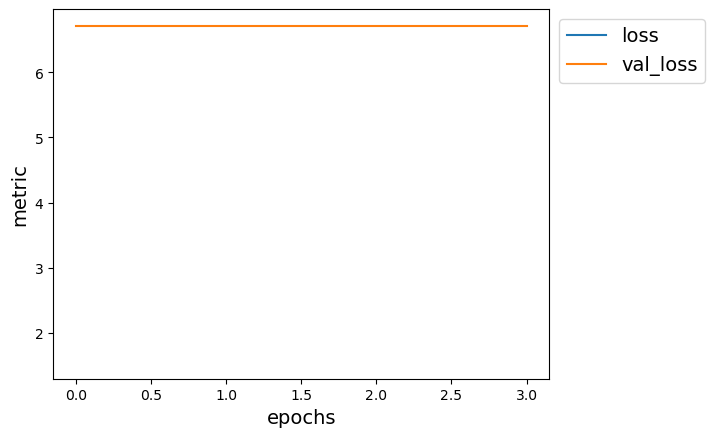

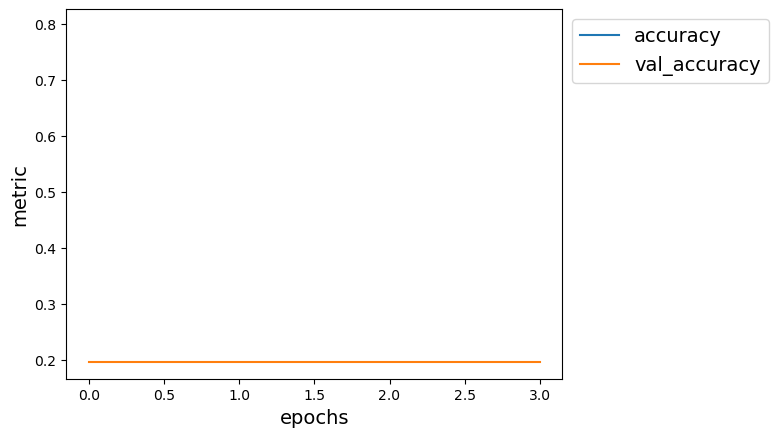

In [ ]:
for model_name, _ in models_dict.items():
    history = history_dict[model_name]["history"]
    history["val_loss"] = [val for val in history["val_loss"] for _ in range(2)]
    history["val_accuracy"] = [val for val in history["val_accuracy"] for _ in range(2)]
    plot_history(model_name, history, ["loss", "val_loss"])
    plot_history(model_name, history, ["accuracy", "val_accuracy"])